In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [16]:
class setup:
    osc_err = 0.1 # super soft error
    
def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

In [8]:
data = mipt.read_excel('data/451.xlsx', usecols=['A', 'B', 'C', 'D'], header=(0)).dropna(how='all')
data

,U11_on,U06_on,U11_off,U06_off
0,9.8,61.2,9.6,58.5
1,9.8,60.9,9.4,58.4
2,9.7,60.6,9.6,58.5
3,9.7,60.9,9.6,58.4
4,9.7,61.2,9.9,58.6


In [52]:
U_aon = data['U06_on']
U_aoff = data['U06_off']
U_bon = data['U11_on']
U_boff = data['U11_off']

G = lambda x: x[0] / x[1]

n = len(U_aon) + 2

errors = np.full(len(U_aon), setup.osc_err)
G_on = G([U_aon, U_bon])
G_on_err, grad = mipt.errcalc(G, [U_aon, U_bon], [errors, errors])

errors = np.full(len(U_aoff), setup.osc_err)
G_off = G([U_aoff, U_boff])
G_off_err, grad = mipt.errcalc(G, [U_aoff, U_boff], [errors, errors])

G_res = G([G_on.mean(), G_off.mean()])
G_on_err = (G_on_err.mean()) / (n**0.5)
G_off_err = (G_off_err.mean()) / (n**0.5)
G_res_err, grad = mipt.errcalc(G, [G_on.mean(), G_off.mean()], [G_on_err, G_off_err])
G_res_err

print('G = {} \pm {}'.format(G_res, G_res_err))

G = 1.0293211239630093 \pm [0.00576072]


In [53]:
data = mipt.read_excel('data/451.xlsx', usecols=['E', 'F'], header=(0)).dropna(how='all')
data

,theta,U
0,0,0.45
1,10,1.16
2,20,2.05
3,30,2.88
4,40,3.54
5,50,4.00
6,60,4.27
7,70,4.50
8,80,4.14
9,90,4.10


a, phi, nu: [  0.97414693 -70.32983769   0.9982854 ]
errors: [0.01187187 1.11657261 0.00570609]


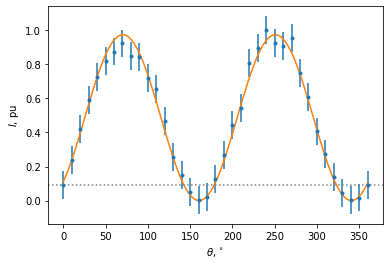

In [97]:
from scipy.optimize import curve_fit

theta = np.array(data['theta'])
u = np.array(data['U']) / np.array(data['U']).max()

mipt.plot(theta, u, func = None, yerr=np.full(len(u), 4 * setup.osc_err/ np.array(data['U']).max()) )

# Find u = a * cos^2(theta + phi)
def cosine(x, a, phi, nu):
    return a * np.cos(nu * np.radians(x) + np.radians(phi))**2

popt, pcov = curve_fit(cosine, theta, u)

t = np.linspace(theta.min(), theta.max(), 100)
plt.plot(t, cosine(t, popt[0], popt[1], popt[2]))

plt.axhline(y=u[0], c='grey', ls=':')

plt.ylabel(r"$I$, pu")
plt.xlabel(r"$\theta, ^\circ$")

plt.savefig("gen/cosine.pdf")

print("a, phi, nu: {}".format(popt))
print("errors: {}".format(np.sqrt(np.diag(pcov))))